In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
from pathlib import Path
from pykml import parser
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import cv2
import sys
sys.path.append('/root/project/OrienterNet')
from maploc.utils.geo import Projection

def get_north(filename):
    with open(filename, 'r') as f:
        kml = parser.parse(f).getroot()
        return kml.GroundOverlay.LatLonBox.north, kml.GroundOverlay.LatLonBox.south

def get_west(filename):
    with open(filename, 'r') as f:
        kml = parser.parse(f).getroot()
        return kml.GroundOverlay.LatLonBox.west, kml.GroundOverlay.LatLonBox.east


water = gpd.read_file('/home/Dataset/semantic/gis_osm_water_a_free_1.shp')
roads = gpd.read_file('/home/Dataset/semantic/gis_osm_roads_free_1.shp')
waterways = gpd.read_file('/home/Dataset/semantic/gis_osm_waterways_free_1.shp')
buildings1 = gpd.read_file('/home/Dataset/semantic/buildings.geojson')
buildings = pd.concat([buildings1])

In [9]:
filename = '/home/Dataset/semantic/remote_image.kml'
ne, _ = get_north(filename)
we, _ = get_west(filename)

_, se = get_north(filename)
_, ee = get_west(filename)

cliper = Polygon(((we, ne), (ee, ne), (ee, se), (we, se), (we, ne)))

buildings = gpd.clip(buildings, cliper)
water = gpd.clip(water, cliper)
roads = gpd.clip(roads, cliper)
waterways = gpd.clip(waterways, cliper)

In [10]:
#1m 0.52m

In [11]:
ee-we

0.0917562942919119

/tmp/ipykernel_812713/1596213078.py:7: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiLineString':
/tmp/ipykernel_812713/1596213078.py:25: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPolygon':
/tmp/ipykernel_812713/1596213078.py:33: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif geometry.type == 'Polygon':
/tmp/ipykernel_812713/1596213078.py:43: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPolygon':
/tmp/ipykernel_812713/1596213078.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and wi

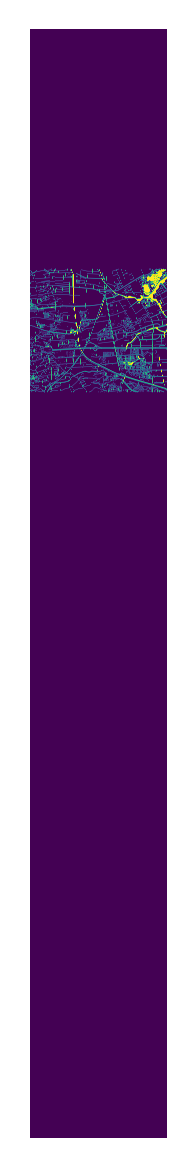

In [12]:
px_lon = 106893.51847
px_lat = 139308.82186
bg = np.zeros((int((ne-se)*px_lat), int((ee-we)*px_lon)), np.uint8)+1

for row in waterways.itertuples():
    geometry = getattr(row, 'geometry')
    if geometry.type == 'MultiLineString':
        for geom in geometry.geoms:
            x = np.array(geom.xy[0]) - float(we)
            x = x * px_lon
            y = float(ne) - np.array(geom.xy[1])
            y = y * px_lat
            area = np.floor(np.dstack((x, y)))[0]
            cv2.polylines(bg, [np.int32(area)], False, (4), 15)
    else:
        x = np.array(geometry.xy[0]) - float(we)
        x = x * px_lon
        y = float(ne) - np.array(geometry.xy[1])
        y = y * px_lat
        area = np.floor(np.dstack((x, y)))[0]
        cv2.polylines(bg, [np.int32(area)], False, (4), 15)

for row in water.itertuples():
    geometry = getattr(row, 'geometry')
    if geometry.type == 'MultiPolygon':
        for geom in geometry.geoms:    
            x = np.array(geom.exterior.xy[0]) - float(we)
            x = x * px_lon
            y = float(ne) - np.array(geom.exterior.xy[1])
            y = y * px_lat
            area = np.floor(np.dstack((x, y)))[0]
            cv2.fillPoly(bg, [np.int32(area)], (4))
    elif geometry.type == 'Polygon':
        x = np.array(geometry.exterior.xy[0]) - float(we)
        x = x * px_lon
        y = float(ne) - np.array(geometry.exterior.xy[1])
        y = y * px_lat
        area = np.floor(np.dstack((x, y)))[0]
        cv2.fillPoly(bg, [np.int32(area)], (4))

for row in buildings.itertuples():
    geometry = getattr(row, 'geometry')
    if geometry.type == 'MultiPolygon':
        for geom in geometry.geoms:    
            x = np.array(geom.exterior.xy[0]) - float(we)
            x = x * px_lon
            y = float(ne) - np.array(geom.exterior.xy[1])
            y = y * px_lat
            area = np.floor(np.dstack((x, y)))[0]
            cv2.fillConvexPoly(bg, np.int32(area), (2))
    elif geometry.type == 'Polygon':
        x = np.array(geometry.exterior.xy[0]) - float(we)
        x = x * px_lon
        y = float(ne) - np.array(geometry.exterior.xy[1])
        y = y * px_lat
        area = np.floor(np.dstack((x, y)))[0]
        cv2.fillConvexPoly(bg, np.int32(area), (2))

for row in roads.itertuples():
    geometry = getattr(row, 'geometry')
    if geometry.type == 'MultiLineString':
        for geom in geometry.geoms:
            x = np.array(geom.xy[0]) - float(we)
            x = x * px_lon
            y = float(ne) - np.array(geom.xy[1])
            y = y * px_lat
            area = np.floor(np.dstack((x, y)))[0]
            cv2.polylines(bg, [np.int32(area)], False, (3), 15)
    else:
        x = np.array(geometry.xy[0]) - float(we)
        x = x * px_lon
        y = float(ne) - np.array(geometry.xy[1])
        y = y * px_lat
        area = np.floor(np.dstack((x, y)))[0]
        cv2.polylines(bg, [np.int32(area)], False, (3), 15)
# cv2.imwrite("qiyuan_semantic.png", bg)
plt.figure(dpi=300)
plt.imshow(bg)
plt.axis('off')
plt.show()

In [49]:
# 图像的左上角的经度和纬度
left_top_lon = we
left_top_lat = ne

# 图像的分辨率（像素/度）
resolution_lon = 1 / px_lon
resolution_lat = 1 / px_lat

# 像素坐标
pixel_x = 100
pixel_y = 200

# 计算经度和纬度的增量
delta_lon = pixel_x * resolution_lon
delta_lat = pixel_y * resolution_lat

# 计算对应的GPS坐标
gps_lon = left_top_lon + delta_lon
gps_lat = left_top_lat - delta_lat  # 注意纬度方向与像素坐标方向相反

print("对应的GPS坐标为：", gps_lon, gps_lat)


对应的GPS坐标为： 116.05781288506564 40.106504776150246


对应的GPS坐标为： 100.0 200.0


In [11]:
def get_xy(target_lat,target_lon):
    # 图像的左上角的经度和纬度
    left_top_lon = we
    left_top_lat = ne

    # 图像的分辨率（像素/度）
    resolution_lon = 1 / px_lon
    resolution_lat = 1 / px_lat

    # 计算GPS坐标与左上角GPS坐标之间的差值
   
    delta_lon = target_lon - left_top_lon
    delta_lat = left_top_lat - target_lat  # 注意纬度方向与像素坐标方向相反

    # 计算经度和纬度的增量
    pixel_x = delta_lon / resolution_lon
    pixel_y = delta_lat / resolution_lat

    return [np.ceil(pixel_x), np.ceil(pixel_y)]

In [10]:
import sys
sys.path.append('/root/project/OrienterNet')
from maploc.utils.geo import BoundaryBox, Projection
all_latlon = []
for i in buildings.geometry.centroid:
    all_latlon.append([i.y,i.x])


def parse_gps_file(path, projection: Projection = None):
    # with open(path, "r") as fid:
    #     print('fid.read(): ',fid.read())
    #     print('fid.read() type: ',type(fid.read()))
    #     lat, lon = map(float, fid.read().split())
    # latlon = np.array([lat, lon])

    all_latlon = []
    with open(path, 'r') as fid:
        for line in fid:
            lat_str, lon_str = line.strip().split()
            latlon_values = [float(lat_str), float(lon_str)]
            all_latlon.append(latlon_values)
    
    return np.array(all_latlon)


gps_path = '/home/Dataset/UAVwithGPS/huaiwei/latlon.txt'
huawei_gps = parse_gps_file(gps_path)
print('all_latlon: ',huawei_gps.shape)
all_latlon = np.vstack((all_latlon, huawei_gps))

projection = Projection.from_points(all_latlon)
all_xy = projection.project(all_latlon)

NameError: name 'buildings' is not defined

In [12]:
def parse_gps_file(path, projection: Projection = None):
    # with open(path, "r") as fid:
    #     print('fid.read(): ',fid.read())
    #     print('fid.read() type: ',type(fid.read()))
    #     lat, lon = map(float, fid.read().split())
    # latlon = np.array([lat, lon])

    all_latlon = []
    with open(path, 'r') as fid:
        for line in fid:
            lat_str, lon_str = line.strip().split()
            latlon_values = [float(lat_str), float(lon_str)]
            all_latlon.append(latlon_values)
    
    return np.array(all_latlon)


gps_path = '/home/Dataset/UAVwithGPS/huaiwei/latlon.txt'
huawei_gps = parse_gps_file(gps_path)
print('all_latlon: ',huawei_gps.shape)

projection = Projection.from_points(huawei_gps)
all_xy = projection.project(all_latlon)

all_latlon:  (632, 2)


AssertionError: 

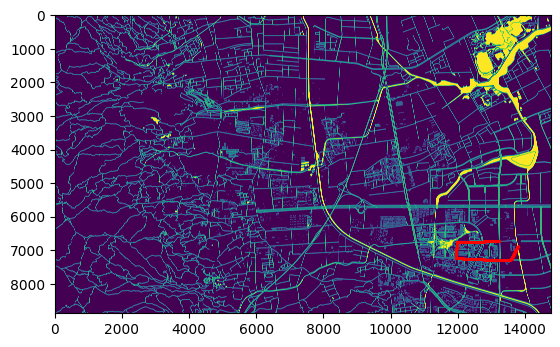

In [32]:
plt.imshow(bg)

height, width = bg.shape

# Calculate the center of the image
center_x = width // 2
center_y = height // 2

for coords in huawei_gps:
    
    coords = get_xy(float(coords[0]),float(coords[1]))
    
    plt.scatter(coords[0], coords[1] , color='red', marker='o', s = 1)

plt.show()

plt.imsave('map.jpg',bg)

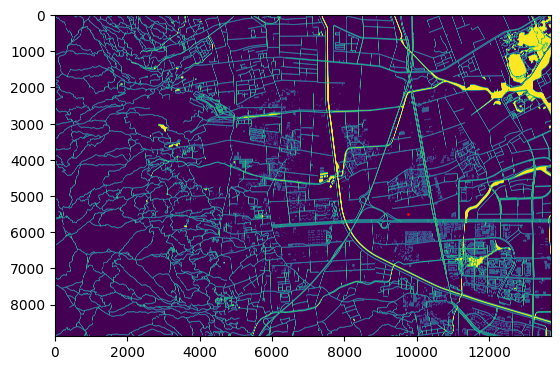

In [10]:
coords = projection.project(huawei_gps[120])
abs_x = center_x + coords[0]
abs_y = center_y - coords[1] 
plt.imshow(bg)
plt.scatter(abs_x, abs_y, color='red', marker='o', s = 1)
plt.show()

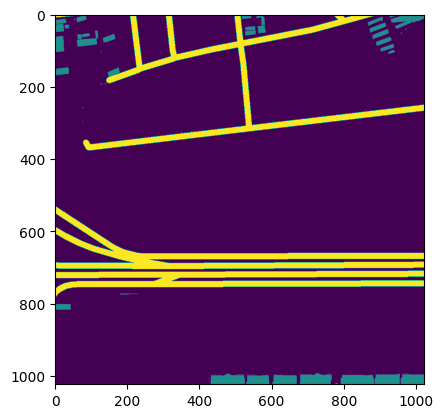

In [11]:
region_size = 1024

# Calculate the coordinates of the top-left corner of the region
top_left_x = int(abs_x - region_size / 2)
top_left_y = int(abs_y - region_size / 2)

# Ensure that the region stays within the bounds of the image
top_left_x = max(0, top_left_x)
top_left_y = max(0, top_left_y)

# Calculate the bottom-right corner coordinates
bottom_right_x = min(top_left_x + region_size, width)
bottom_right_y = min(top_left_y + region_size, height)

# Extract the region from the background image
region = bg[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

# Plot the extracted region
plt.imshow(region)
plt.show()

In [33]:
import pickle
qiyuan = {'bg':bg,'we':we,'ne':ne,'px_lat':px_lat,'px_lon':px_lon}
# Save the projection object to a file
with open('qiyuan.pkl', 'wb') as f:
    pickle.dump(qiyuan, f)


In [5]:
with open('/root/project/OrienterNet/datasets/huawei/qiyuan.pkl', 'rb') as f:
    qiyuan_read = pickle.load(f)

In [6]:
qiyuan_read

{'bg': array([[1, 1, 1, ..., 3, 3, 3],
        [1, 1, 1, ..., 3, 3, 3],
        [1, 1, 1, ..., 3, 3, 3],
        ...,
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2]], dtype=uint8),
 'we': 116.056877374649,
 'ne': 40.1079404354095,
 'px_lat': 139308.82186,
 'px_lon': 106893.51847}

In [13]:
def parse_gps_file(path, projection: Projection = None):
    # with open(path, "r") as fid:
    #     print('fid.read(): ',fid.read())
    #     print('fid.read() type: ',type(fid.read()))
    #     lat, lon = map(float, fid.read().split())
    # latlon = np.array([lat, lon])

    all_latlon = []
    with open(path, 'r') as fid:
        for line in fid:
            lat_str, lon_str = line.strip().split()
            latlon_values = [float(lat_str), float(lon_str)]
            all_latlon.append(latlon_values)
    
    return np.array(all_latlon)


gps_path = '/home/Dataset/UAVwithGPS/huaiwei/latlon.txt'
huawei_gps = parse_gps_file(gps_path)
print('all_latlon: ',huawei_gps.shape)

all_latlon:  (632, 2)


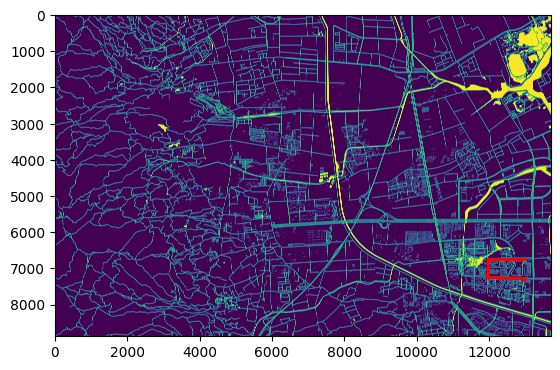

In [28]:
bg = qiyuan_read['bg']
plt.imshow(bg)

height, width = bg.shape

# Calculate the center of the image
center_x = width // 2
center_y = height // 2

for coords in huawei_gps:
    if float(coords[1]) < 116.17849372881223:
        coords = get_xy(float(coords[0]),float(coords[1]))
        
        plt.scatter(coords[0], coords[1] , color='red', marker='o', s = 1)

plt.show()

plt.imsave('map.jpg',bg)


In [26]:
# 图像的左上角的经度和纬度
left_top_lon = we
left_top_lat = ne

# 图像的分辨率（像素/度）
resolution_lon = 1 / px_lon
resolution_lat = 1 / px_lat

# 像素坐标
pixel_x = 13000
pixel_y = 1789

# 计算经度和纬度的增量
delta_lon = pixel_x * resolution_lon
delta_lat = pixel_y * resolution_lat

# 计算对应的GPS坐标
gps_lon = left_top_lon + delta_lon
gps_lat = left_top_lat - delta_lat  # 注意纬度方向与像素坐标方向相反

print("对应的GPS坐标为：", gps_lon, gps_lat)


对应的GPS坐标为： 116.17849372881223 40.09509846333542


In [34]:
import torch
embedding = torch.nn.Embedding(4, 16)
result = embedding(torch.tensor(region,dtype=torch.long))

In [35]:
result

tensor([[[ 0.5597, -1.3261,  0.7353,  ..., -0.5114,  1.5321, -0.2861],
         [ 0.5597, -1.3261,  0.7353,  ..., -0.5114,  1.5321, -0.2861],
         [ 0.5597, -1.3261,  0.7353,  ..., -0.5114,  1.5321, -0.2861],
         ...,
         [-0.1610,  1.6150,  0.2980,  ...,  1.3198, -0.1613,  0.5871],
         [-0.1610,  1.6150,  0.2980,  ...,  1.3198, -0.1613,  0.5871],
         [-0.1610,  1.6150,  0.2980,  ...,  1.3198, -0.1613,  0.5871]],

        [[ 0.5597, -1.3261,  0.7353,  ..., -0.5114,  1.5321, -0.2861],
         [ 0.5597, -1.3261,  0.7353,  ..., -0.5114,  1.5321, -0.2861],
         [ 0.5597, -1.3261,  0.7353,  ..., -0.5114,  1.5321, -0.2861],
         ...,
         [-0.1610,  1.6150,  0.2980,  ...,  1.3198, -0.1613,  0.5871],
         [-0.1610,  1.6150,  0.2980,  ...,  1.3198, -0.1613,  0.5871],
         [-0.1610,  1.6150,  0.2980,  ...,  1.3198, -0.1613,  0.5871]],

        [[ 0.5597, -1.3261,  0.7353,  ..., -0.5114,  1.5321, -0.2861],
         [ 0.5597, -1.3261,  0.7353,  ..., -0

In [36]:
region.max()

3

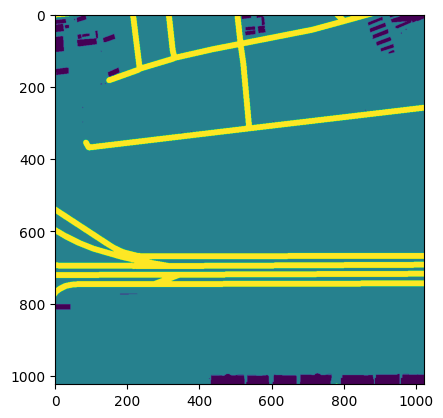

In [37]:
plt.imshow(result.permute(2,0,1)[4].cpu().detach().numpy())